In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
im_s = 32

transform = transforms.Compose([
    transforms.Resize(im_s),
    transforms.CenterCrop(im_s),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

In [4]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)

In [5]:
train_dataset = ImageFolderWithPaths(
    root='./dataset/',
    transform=transform
)
batch_size=20
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=6,
    shuffle=True,
    drop_last=True
)
print(train_dataset.classes)

['cube']


In [6]:
def imshow(img):
    # npimg in (channel, height, width)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 32, 32])


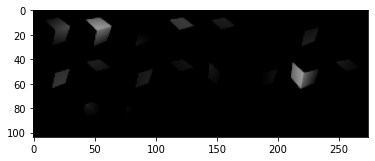

In [7]:
# get some random training images
dataiter = iter(train_loader)
quick_images, quick_labels, quick_paths = dataiter.next()

print(quick_images.shape)

imshow(torchvision.utils.make_grid(quick_images))

In [8]:
img_shape = (1, im_s, im_s)
cuda = True if torch.cuda.is_available() else False

In [9]:
class cluster_NN(nn.Module):
    def __init__(self, level, xy):
        super(cluster_NN, self).__init__()
        self.level = level # dummy
        self.pixel = xy # dummy
        self.model = nn.Sequential(
            # Pixel Coord + Light Coord + Average Pixel Color
            nn.Linear(2 + 2 + 1, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Tanh()
        )
    def forward(self, pixel_coord, light_coord, average_rgb):
        d_in = torch.cat((pixel_coord, light_coord, average_rgb), -1)
        rgb = self.model(d_in)
        return rgb

In [10]:
# Loss functions
loss = torch.nn.MSELoss()
if cuda:
    loss.cuda()

In [11]:
num_weights = 5 * 16 + 16 * 16 + 16 * 16 + 16
num_images = 120
num_pixels = im_s * im_s
lv0_num_clus = int(num_pixels / 25 * num_weights / num_images)
print(lv0_num_clus)
max_lvl = 3

207


In [12]:
cluster_lvl = []
optimizer_lvl = []

cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
optimizer_0 = []
optimizer_1 = []
optimizer_2 = []
optimizer_3 = []

# Initialize all cluster NN
for i in range(lv0_num_clus):
    xy = np.random.uniform(0, 1, (2, ))
    nun = cluster_NN(0, (xy[0],xy[1]))
    if cuda:
        nun.cuda()
    cluster_0 += [nun]
    optimizer_0 += [torch.optim.Adam(nun.parameters(), lr=0.001, betas=(0.9, 0.999))]

for i in range(int(lv0_num_clus / 4)):
    xy = np.random.uniform(0, 1, (2, ))
    nun = cluster_NN(1, (xy[0],xy[1]))
    if cuda:
        nun.cuda()
    cluster_1 += [nun]
    optimizer_1 += [torch.optim.Adam(nun.parameters(), lr=0.001, betas=(0.9, 0.999))]

for i in range(int(lv0_num_clus / 4 / 4)):
    xy = np.random.uniform(0, 1, (2, ))
    nun = cluster_NN(2, (xy[0],xy[1]))
    if cuda:
        nun.cuda()
    cluster_2 += [nun]
    optimizer_2 += [torch.optim.Adam(nun.parameters(), lr=0.001, betas=(0.9, 0.999))]

for i in range(int(lv0_num_clus / 4 / 4 / 4)):
    xy = np.random.uniform(0, 1, (2, ))
    nun = cluster_NN(3, (xy[0],xy[1]))
    if cuda:
        nun.cuda()
    cluster_3 += [nun]
    optimizer_3 += [torch.optim.Adam(nun.parameters(), lr=0.001, betas=(0.9, 0.999))]
    
cluster_lvl += [cluster_0, cluster_1, cluster_2, cluster_3]
optimizer_lvl += [optimizer_0, optimizer_1, optimizer_2, optimizer_3]
len(cluster_lvl)
len(optimizer_lvl)

4

In [13]:
from sklearn.neighbors import NearestNeighbors

knns = []

for i in range(len(cluster_lvl)):
    print('level %i' % i)
    length = len(cluster_lvl[i])
    samples = np.array(list(map(lambda x: x.pixel, cluster_lvl[i])))
    knn = NearestNeighbors(n_neighbors=length)
    knn.fit(samples, )
    knns += [knn]

level 0
level 1
level 2
level 3


In [14]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
CharTensor = torch.cuda.CharTensor if cuda else torch.CharTensor

In [15]:
# Compute Average Color of All Pixels of All Images
def avg_save(path):
    dic = dict()
    total_image = 0
    for i, data in enumerate(train_loader):
        imgs,labels,paths = data
        # x, y positions of the light
        batch_size = imgs.shape[0]
        num_channel = imgs.shape[1]
        width = imgs.shape[2]
        height = imgs.shape[3]
        total_image += batch_size
        # print(batch_size, num_channel, width, height)
        for k in range(batch_size):
            for i in range(width):
                for j in range(height):
                    key_name = str(i) + '-' + str(j)
                    if key_name in dic:
                        dic[key_name] = imgs[k, 0, i, j] + dic[key_name]
                    else:
                        dic[key_name] = imgs[k, 0, i, j]
    avg_img = []
    for j in range(height):
        for i in range(width):
            key_name = str(i) + '-' + str(j)
            avg_img += [dic[key_name] / total_image]
    print(total_image)
    np.save(path, np.array(avg_img))

In [16]:
# avg_img = avg_save('avg_basketball_32')
loaded_avg_img = np.load('./avg/avg_cube_32.npy')

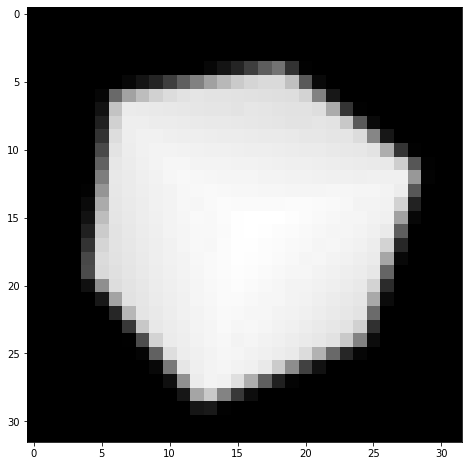

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(loaded_avg_img.reshape(img_shape[1],img_shape[2], order='F') * .5 + .5, cmap='gray', )

In [18]:
def sample_image(n_row, loaded_avg_img, lr=0, lc=0):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    width = img_shape[1]
    height = img_shape[2]
    avg_img = torch.from_numpy(loaded_avg_img).to(device)
    avg_img = Variable(avg_img.type(FloatTensor))
    img_tensor = torch.FloatTensor().to(device)
    for k in range(height):
        for j in range(width):
            # Pixel Coord + Light Coord + Average Pixel Color
            avg_value = Variable(avg_img[j + k * width].repeat(1, n_row).view(n_row, 1).type(FloatTensor))
            pixel_coord = Variable(torch.FloatTensor([j/width, k/height])).repeat(1, n_row).view(n_row, 2).to(device)
            # Default sample location is the light in the middle
            light_coord = Variable(torch.FloatTensor([lr, lc])).repeat(1, n_row).view(n_row, 2).to(device)
            lvl = pixel_lvls[str(j) + '-' + str(k)]
            size_of_cluster = min(5, len(cluster_lvl[lvl]))
            top_nn_idxs = knns[lvl].kneighbors([[j/width,k/height]], return_distance=False)[0][:size_of_cluster]
            gen_pix = None
            for idx in top_nn_idxs:
                if gen_pix == None:
                    gen_pix = cluster_lvl[lvl][idx](pixel_coord, light_coord, avg_value)
                else:
                    gen_pix += cluster_lvl[lvl][idx](pixel_coord, light_coord, avg_value)
            gen_pix /= size_of_cluster
            img_tensor = torch.cat((img_tensor, gen_pix), 1)
    
    print(img_tensor.shape)
    plt.imshow(img_tensor.cpu().data.detach().numpy().reshape(img_shape[1],img_shape[2],order='F') * .5 + .5, cmap='gray', vmin=0,
              vmax=1)

In [120]:
def reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()
for i in range(len(cluster_lvl)):
    for j in range(len(cluster_lvl[i])):
        cluster_lvl[i][j].apply(reset)

In [121]:
pixel_lvls = dict()

In [122]:
# for inference
def update_pixel(x, y, lvl, epoch):
    key_name = str(x) + '-' + str(y)
    if key_name in pixel_lvls:
        if pixel_lvls[key_name] > lvl and epoch == 5:
            pixel_lvls[key_name] = lvl
    else:
        pixel_lvls[key_name] = lvl

torch.Size([1, 1024])


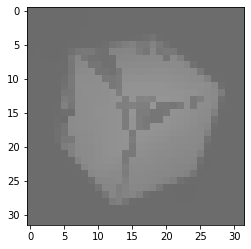

In [125]:
from IPython.display import clear_output
epochs = 10

# num_weights = 5 * 16 + 16 * 16 + 16 * 16 + 16
# num_images = 120
# lv0_num_clus = int(25 * num_weights / num_images)
# max_lvl = 3

for epoch in range(epochs):
    # Iterate all images before calculate the loss of a single pixel
    for i, data in enumerate(train_loader):
#         optimizer.zero_grad()
        imgs,labels,paths = data
        paths = np.array([path.split('/')[-1][:-4].split('_') for path in paths]).astype(float)
        paths /= 10.0 # normalize
        positions = torch.from_numpy(paths).to(device)
        avg_img = torch.from_numpy(loaded_avg_img).to(device)
        imgs = imgs.to(device)
        batch_size = imgs.shape[0]
        width = imgs.shape[2]
        height = imgs.shape[3]
        
        avg_img = Variable(avg_img.type(FloatTensor))
        light_coord = Variable(positions.type(FloatTensor))
        
        for k in range(im_s):
            for j in range(im_s):
                pixel_value = Variable(imgs[:, 0, j, k].view(20, 1).type(FloatTensor))
                pixel_coord = Variable(torch.FloatTensor([j/width, k/height])).repeat(1, 20).view(20, 2).to(device)
                avg_value = Variable(avg_img[j + k * width].repeat(1, 20).view(20, 1).type(FloatTensor))
                level = max_lvl
                # find 3 or 5 nearest NN
                size_of_cluster = min(5, len(cluster_lvl[level]))
                top_nn_idxs = knns[level].kneighbors([[j/width,k/height]], return_distance=False)[0][:size_of_cluster]
                total_loss = None
                # zerograd the coarest level
                for idx in top_nn_idxs:
                    optimizer_lvl[level][idx].zero_grad()
                # run ensemble and average
                # measure the training error on the batch
                for idx in top_nn_idxs:
                    gen_pix = cluster_lvl[level][idx](pixel_coord, light_coord, avg_value)
                    if total_loss == None:
                        total_loss = loss(gen_pix, pixel_value / size_of_cluster)
                    else:
                        total_loss += loss(gen_pix, pixel_value / size_of_cluster)
                losses = total_loss.item()
                total_loss.backward()
                for idx in top_nn_idxs:
                    optimizer_lvl[level][idx].step()
                update_pixel(j, k, level, i + 1)
                print(
                        "[Epoch %d/%d] [Batch %d/%d] [Pixel %d-%d] [Level %d] [Loss: %f]"
                        % (epoch + 1, epochs, i + 1, len(train_loader), j, k, level, losses)
                    )
                while losses / torch.pow(torch.norm(pixel_value), 2).item() > 0.0073 and level > 0:
                    level -= 1
                    for idx in top_nn_idxs:
                        optimizer_lvl[level][idx].zero_grad()
                    size_of_cluster = min(5, len(cluster_lvl[level]))
                    top_nn_idxs = knns[level].kneighbors([[j/width,k/height]], return_distance=False)[0][:size_of_cluster]
                    total_loss = None
                    # run ensemble and average
                    # measure the training error on the batch
                    for idx in top_nn_idxs:
                        gen_pix = cluster_lvl[level][idx](pixel_coord, light_coord, avg_value)
                        if total_loss == None:
                            total_loss = loss(gen_pix, pixel_value / size_of_cluster)
                        else:
                            total_loss += loss(gen_pix, pixel_value / size_of_cluster)
                    losses = total_loss.item()
                    # back_prop will perform for individual network
                    total_loss.backward()
                    for idx in top_nn_idxs:
                        optimizer_lvl[level][idx].step()
                    update_pixel(j, k, level, i + 1)
                    print(
                        "[Epoch %d/%d] [Batch %d/%d] [Pixel %d-%d] [Level %d] [Loss: %f]"
                        % (epoch + 1, epochs, i + 1, len(train_loader), j, k, level, losses)
                    )
        clear_output(wait=True)
        sample_image(1, loaded_avg_img)
        plt.show()

In [59]:
from ipywidgets import interact

def test(lr, lc):
    sample_image(1, loaded_avg_img, lr, lc)
    
interact(test, lr=(-1, 1, .1), lc=(-1, 1, .1))

interactive(children=(FloatSlider(value=0.0, description='lr', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.test(lr, lc)>

In [ ]:
def save_models(model, path):
    # max_level is 3
    checkpoint = {'model': model,
          'state_dicts': [[cluster_lvl[j][i].state_dict() for i in range(len(cluster_lvl[j]))] for j in range(len(cluster_lvl))],
          'optimizers' : [[optimizer_lvl[j][i].state_dict() for i in range(len(optimizer_lvl[j]))] for j in range(len(optimizer_lvl))],
          'num_clusters' : [len(cluster_lvl[i]) for i in range(len(cluster_lvl))],
          'knns' : knns,
          'pixel_dict' : pixel_lvls}
    torch.save(checkpoint, path)

In [ ]:
# len([cluster_lvl[j][i].state_dict() for j in range(len(cluster_lvl)) for i in range(len(cluster_lvl[j]))])

In [ ]:
copy_cluster_lvl = []

copy_cluster_0 = []
copy_cluster_1 = []
copy_cluster_2 = []
copy_cluster_3 = []

copy_knns = None
copy_pixel_dict = None

copy_cluster_lvl = [copy_cluster_0, copy_cluster_1, copy_cluster_2, copy_cluster_3]

def load_models(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    state_dicts = checkpoint['state_dicts']
    num_clusters = checkpoint['num_clusters']
    global copy_knns
    global copy_pixel_dict
    copy_knns = checkpoint['knns']
    copy_pixel_dict = checkpoint['pixel_dict']
    for i in range(len(num_clusters)):
        for j in range(num_clusters[i]):
            model_real = cluster_NN(3, (1,1))
            model_real.load_state_dict(state_dicts[i][j])
            for parameter in model_real.parameters():
                parameter.requires_grad = False
            model_real.eval().to(device)
            copy_cluster_lvl[i] += [model_real]

In [ ]:
# xy & level of NN() is not being used anywhere
save_models(cluster_NN(3, (1,1)), './check_pt/trained_adaptive_cube.pth')

In [ ]:
load_models('./check_pt/trained_adaptive_cube_32_200.pth')

In [ ]:
def sample_trained(n_row, loaded_avg_img, lr=0, lc=0):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    width = img_shape[1]
    height = img_shape[2]
    avg_img = torch.from_numpy(loaded_avg_img).to(device)
    avg_img = Variable(avg_img.type(FloatTensor))
    img_tensor = torch.FloatTensor().to(device)
    for k in range(height):
        for j in range(width):
            # Pixel Coord + Light Coord + Average Pixel Color
            avg_value = Variable(avg_img[j + k * width].repeat(1, n_row).view(n_row, 1).type(FloatTensor))
            pixel_coord = Variable(torch.FloatTensor([j/width, k/height])).repeat(1, n_row).view(n_row, 2).to(device)
            # Default sample location is the light in the middle
            light_coord = Variable(torch.FloatTensor([lr, lc])).repeat(1, n_row).view(n_row, 2).to(device)
            lvl = copy_pixel_dict[str(j) + '-' + str(k)]
            size_of_cluster = min(5, len(copy_cluster_lvl[lvl]))
            top_nn_idxs = copy_knns[lvl].kneighbors([[j/width,k/height]], return_distance=False)[0][:size_of_cluster]
            gen_pix = None
            for idx in top_nn_idxs:
                if gen_pix == None:
                    gen_pix = copy_cluster_lvl[lvl][idx](pixel_coord, light_coord, avg_value)
                else:
                    gen_pix += copy_cluster_lvl[lvl][idx](pixel_coord, light_coord, avg_value)
            gen_pix /= size_of_cluster
            img_tensor = torch.cat((img_tensor, gen_pix), 1)
    
    print(img_tensor.shape)
    plt.imshow(img_tensor.cpu().data.detach().numpy().reshape(img_shape[1],img_shape[2],order='F') * .5 + .5, cmap='gray', vmin=0,
              vmax=1)

In [ ]:
from ipywidgets import interact

def test(lr, lc):
    sample_trained(1, loaded_avg_img, lr, lc)
    
interact(test, lr=(-1, 1, .1), lc=(-1, 1, .1))

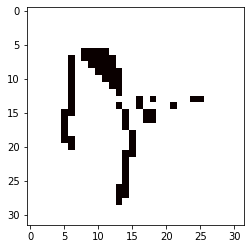

In [124]:
a = np.random.random((32,32))
for x in range(32):
    for y in range(32):
        key_name = str(x) + '-' + str(y)
        a[x,y] = pixel_lvls[key_name]
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()